### Assignment - 1

#### 1. Load and Inspect the CMAPSS Dataset
Task:
- Write Python code to load the raw `train_FD001.txt` dataset for CMAPSS using Pandas, assign appropriate column names, and display the shape, data types, and first 5 rows of the DataFrame.
- Expected Output: DataFrame shape, info, and sample rows.

Use the link to download the dataset:
https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data

In [1]:
# load_cmapss_fd001.py
import os
import pandas as pd
import sys

# path to the file (change if your file is elsewhere)
file_path = "/train_FD001.txt"

# Column names per CMAPSS: unit#, cycle, 3 settings, 26 sensors => total 30 columns
col_names = (
    ["unit_number", "time_in_cycles",
     "operational_setting_1", "operational_setting_2", "operational_setting_3"]
    + [f"sensor_measurement_{i}" for i in range(1, 27)]
)

def load_cmapss(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(
            f"File not found: {file_path}\n"
            "Please download train_FD001.txt from the CMAPSS dataset page and place it here,"
            " or update the file_path variable to the correct location."
        )

    # The file uses whitespace separators (multiple spaces); use sep='\s+'
    df = pd.read_csv(file_path, sep=r"\s+", header=None, names=col_names)
    return df

def main():
    try:
        df = load_cmapss(file_path)
    except FileNotFoundError as e:
        print(e)
        sys.exit(1)
    except Exception as e:
        print("Error reading the file:", str(e))
        sys.exit(1)

    # 1. Shape
    print("DataFrame shape:", df.shape)
    print()

    # 2. DataFrame info (dtypes and non-null counts)
    print("DataFrame info():")
    # Using buffer to capture info() output neatly
    df.info()
    print()

    # 3. Data types (explicit)
    print("Data types:\n", df.dtypes)
    print()

    # 4. First 5 rows
    print("First 5 rows:")
    print(df.head(5).to_string(index=False))

if __name__ == "__main__":
    main()


DataFrame shape: (20631, 31)

DataFrame info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unit_number            20631 non-null  int64  
 1   time_in_cycles         20631 non-null  int64  
 2   operational_setting_1  20631 non-null  float64
 3   operational_setting_2  20631 non-null  float64
 4   operational_setting_3  20631 non-null  float64
 5   sensor_measurement_1   20631 non-null  float64
 6   sensor_measurement_2   20631 non-null  float64
 7   sensor_measurement_3   20631 non-null  float64
 8   sensor_measurement_4   20631 non-null  float64
 9   sensor_measurement_5   20631 non-null  float64
 10  sensor_measurement_6   20631 non-null  float64
 11  sensor_measurement_7   20631 non-null  float64
 12  sensor_measurement_8   20631 non-null  float64
 13  sensor_measurement_9   20631 non-null  float64
 14  sensor

#### 2. Visualize Sensor Distributions and Identify Missing Values
Task:
- Using the loaded dataset (or the cleaned version), visualize the distribution of values for any three sensor columns with histograms, and check for missing values in all columns.
- Expected Output: Three histogram plots and a summary/report on missing values per column.

 Missing Values Summary (per column):
sensor_measurement_22    20631
sensor_measurement_23    20631
sensor_measurement_24    20631
sensor_measurement_25    20631
sensor_measurement_26    20631
dtype: int64


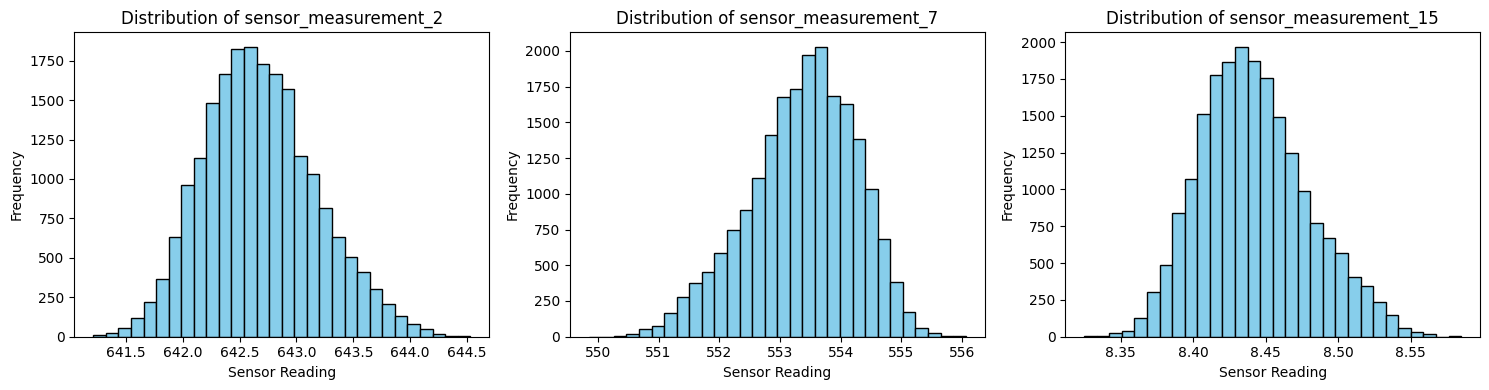

In [4]:
# visualize_sensors_and_missing_values.py
import pandas as pd
import matplotlib.pyplot as plt

# === Step 1: Load the dataset ===
col_names = (
    ["unit_number", "time_in_cycles",
     "operational_setting_1", "operational_setting_2", "operational_setting_3"]
    + [f"sensor_measurement_{i}" for i in range(1, 27)]
)

# Make sure the file path points to your downloaded CMAPSS file
df = pd.read_csv("/train_FD001.txt", sep=r"\s+", header=None, names=col_names)

# === Step 2: Check for missing values ===
missing_values = df.isnull().sum()
print(" Missing Values Summary (per column):")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "✅ No missing values found!")

# === Step 3: Select 3 sensor columns for visualization ===
sensor_cols = ["sensor_measurement_2", "sensor_measurement_7", "sensor_measurement_15"]

# === Step 4: Plot histograms for the selected sensors ===
plt.figure(figsize=(15, 4))

for i, col in enumerate(sensor_cols, 1):
    plt.subplot(1, 3, i)
    plt.hist(df[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel("Sensor Reading")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


#### 3. Feature Engineering – Aggregation and Rolling Statistics
Task:
- For a selected sensor (e.g., `sensor_2`), compute and append to the DataFrame:
  - The mean and standard deviation of `sensor_2` by each `engine_id`

  - The rolling mean (window size=5) for each engine’s `sensor_2` readings
- Expected Output: Show a few sample rows with these new features.

In [6]:
import pandas as pd

# Step 1: Load the dataset (if not already loaded)
col_names = (
    ["unit_number", "time_in_cycles",
     "operational_setting_1", "operational_setting_2", "operational_setting_3"]
    + [f"sensor_measurement_{i}" for i in range(1, 27)]
)
df = pd.read_csv("/train_FD001.txt", sep=r"\s+", header=None, names=col_names)

# Drop inactive sensors (as found earlier)
inactive_sensors = ["sensor_measurement_22", "sensor_measurement_23",
                    "sensor_measurement_24", "sensor_measurement_25",
                    "sensor_measurement_26"]
df = df.drop(columns=inactive_sensors)

# Step 2: Select the target sensor
sensor = "sensor_measurement_2"

# Step 3: Compute mean and std deviation by each engine (unit_number)
sensor_stats = df.groupby("unit_number")[sensor].agg(
    sensor_mean="mean",
    sensor_std="std"
).reset_index()

# Merge the stats back to the main DataFrame
df = df.merge(sensor_stats, on="unit_number", how="left")

# Step 4: Compute rolling mean (window=5) per engine
df["rolling_mean_sensor2"] = (
    df.groupby("unit_number")[sensor]
      .rolling(window=5, min_periods=1)
      .mean()
      .reset_index(level=0, drop=True)
)

# Step 5: Display a few rows to check results
print("Feature engineering completed! Sample rows:")
print(df[["unit_number", "time_in_cycles", sensor,
          "sensor_mean", "sensor_std", "rolling_mean_sensor2"]].head(10))


Feature engineering completed! Sample rows:
   unit_number  time_in_cycles  sensor_measurement_2  sensor_mean  sensor_std  \
0            1               1                641.82   642.621042    0.486795   
1            1               2                642.15   642.621042    0.486795   
2            1               3                642.35   642.621042    0.486795   
3            1               4                642.35   642.621042    0.486795   
4            1               5                642.37   642.621042    0.486795   
5            1               6                642.10   642.621042    0.486795   
6            1               7                642.48   642.621042    0.486795   
7            1               8                642.56   642.621042    0.486795   
8            1               9                642.12   642.621042    0.486795   
9            1              10                641.71   642.621042    0.486795   

   rolling_mean_sensor2  
0            641.820000  
1           

#### 4. Data Normalization
Task:
- Normalize all sensor columns in the DataFrame using `StandardScaler` from `scikit-learn` (zero mean, unit variance) and create a new DataFrame, maintaining the original `engine_id` and `cycle` columns.
- Expected Output: Head of the normalized DataFrame and a check that means are close to zero, std are close to one.

In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Step 1: Load cleaned dataset (reuse from previous step)
col_names = (
    ["unit_number", "time_in_cycles",
     "operational_setting_1", "operational_setting_2", "operational_setting_3"]
    + [f"sensor_measurement_{i}" for i in range(1, 27)]
)
df = pd.read_csv("/train_FD001.txt", sep=r"\s+", header=None, names=col_names)

# Drop inactive sensors (22–26)
inactive_sensors = ["sensor_measurement_22", "sensor_measurement_23",
                    "sensor_measurement_24", "sensor_measurement_25",
                    "sensor_measurement_26"]
df = df.drop(columns=inactive_sensors)

# Step 2: Select only sensor columns (1–21)
sensor_cols = [f"sensor_measurement_{i}" for i in range(1, 22)]

# Step 3: Apply StandardScaler
scaler = StandardScaler()
sensor_scaled = scaler.fit_transform(df[sensor_cols])

# Step 4: Create a new normalized DataFrame
df_normalized = pd.DataFrame(sensor_scaled, columns=sensor_cols)

# Step 5: Add back engine ID and cycle columns
df_normalized.insert(0, "time_in_cycles", df["time_in_cycles"])
df_normalized.insert(0, "unit_number", df["unit_number"])

# Step 6: Show head of normalized DataFrame
print("Normalized DataFrame (first 5 rows):")
print(df_normalized.head())

# Step 7: Verify that means ≈ 0 and std ≈ 1
print("\n Check mean and std for normalized sensors:")
print(df_normalized[sensor_cols].agg(['mean', 'std']).round(3))


Normalized DataFrame (first 5 rows):
   unit_number  time_in_cycles  sensor_measurement_1  sensor_measurement_2  \
0            1               1                   0.0             -1.721725   
1            1               2                   0.0             -1.061780   
2            1               3                   0.0             -0.661813   
3            1               4                   0.0             -0.661813   
4            1               5                   0.0             -0.621816   

   sensor_measurement_3  sensor_measurement_4  sensor_measurement_5  \
0             -0.134255             -0.925936         -1.776357e-15   
1              0.211528             -0.643726         -1.776357e-15   
2             -0.413166             -0.525953         -1.776357e-15   
3             -1.261314             -0.784831         -1.776357e-15   
4             -1.251528             -0.301518         -1.776357e-15   

   sensor_measurement_6  sensor_measurement_7  sensor_measurement_8

#### 5. Rolling Window Sequence Generation
Task:
- Write a function to generate rolling window sequences of length 30 for the sensors of each engine. Save the resulting 3D NumPy array (num_sequences, window_size, num_features), and save the corresponding engine_id and cycle identifier lists as CSV files. Print the shape of the resulting sequence array and contents of the first entry.
- Expected Output: Array shape, example content, and confirmation of successful file saves.

In [9]:
# rolling_sequences_generation.py
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def load_and_clean(file_path="train_FD001.txt"):
    # Column names (30 columns in original raw file)
    col_names = (
        ["unit_number", "time_in_cycles",
         "operational_setting_1", "operational_setting_2", "operational_setting_3"]
        + [f"sensor_measurement_{i}" for i in range(1, 27)]
    )
    df = pd.read_csv(file_path, sep=r"\s+", header=None, names=col_names)
    # Drop the known inactive sensors for FD001 (22-26)
    inactive = [f"sensor_measurement_{i}" for i in range(22, 27)]
    df = df.drop(columns=inactive)
    return df

def standardize_sensors(df, sensor_cols):
    scaler = StandardScaler()
    sensors_scaled = scaler.fit_transform(df[sensor_cols])
    df_scaled = df.copy()
    df_scaled[sensor_cols] = sensors_scaled
    return df_scaled, scaler

def generate_rolling_sequences(df, sensor_cols, window_size=30):
    """
    Returns:
      sequences: np.ndarray, shape = (num_sequences, window_size, num_features)
      seq_engine_ids: list of engine ids (unit_number) for each sequence
      seq_cycle_ids: list of cycle ids (time_in_cycles) for each sequence (we use the last cycle of the window)
    """
    sequences = []
    seq_engine_ids = []
    seq_cycle_ids = []

    # Group by engine
    grouped = df.groupby("unit_number", sort=True)

    for engine_id, group in grouped:
        # sort by cycle just in case
        group_sorted = group.sort_values("time_in_cycles")
        sensor_data = group_sorted[sensor_cols].values  # shape: (num_cycles_for_engine, num_features)
        cycles = group_sorted["time_in_cycles"].values

        n_cycles = sensor_data.shape[0]
        if n_cycles < window_size:
            # If engine has fewer cycles than window, skip (alternatively you could pad)
            continue

        # sliding windows, stride = 1
        for start in range(0, n_cycles - window_size + 1):
            end = start + window_size
            window = sensor_data[start:end]  # shape: (window_size, num_features)
            sequences.append(window)
            seq_engine_ids.append(engine_id)
            seq_cycle_ids.append(int(cycles[end - 1]))  # last cycle in this window

    if len(sequences) == 0:
        # no sequences found
        sequences_arr = np.empty((0, window_size, len(sensor_cols)))
    else:
        sequences_arr = np.stack(sequences, axis=0)

    return sequences_arr, seq_engine_ids, seq_cycle_ids

def save_outputs(sequences_arr, engine_ids, cycle_ids,
                 seq_file="sensor_sequences.npy",
                 engine_csv="sequence_engine_ids.csv",
                 cycle_csv="sequence_cycle_ids.csv"):
    # Save numpy array
    np.save(seq_file, sequences_arr)
    # Save CSVs (one column)
    pd.DataFrame({"unit_number": engine_ids}).to_csv(engine_csv, index=False)
    pd.DataFrame({"last_cycle": cycle_ids}).to_csv(cycle_csv, index=False)
    return seq_file, engine_csv, cycle_csv

if __name__ == "__main__":
    file_path = "/train_FD001.txt"
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"{file_path} not found. Please download and place it here.")

    # 1) Load & clean
    df = load_and_clean(file_path)

    # 2) sensor cols 1..21
    sensor_cols = [f"sensor_measurement_{i}" for i in range(1, 22)]

    # 3) Standardize sensors (optional but recommended)
    df_scaled, scaler = standardize_sensors(df, sensor_cols)

    # 4) Generate sequences
    WINDOW = 30
    sequences, engine_ids, cycle_ids = generate_rolling_sequences(df_scaled, sensor_cols, window_size=WINDOW)

    # 5) Save outputs
    seq_file, engine_csv, cycle_csv = save_outputs(sequences, engine_ids, cycle_ids)

    # 6) Print results
    print("✅ Sequence generation complete.")
    print(f"Saved sequences to: {seq_file}")
    print(f"Saved engine IDs to: {engine_csv}")
    print(f"Saved cycle IDs to: {cycle_csv}")
    print()

    # Shape of 3D array
    print("Sequences array shape:", sequences.shape)  # (num_sequences, window_size, num_features)
    if sequences.shape[0] > 0:
        # Print a compact view of the first entry
        num_features = sequences.shape[2]
        print("\nFirst sequence (sequence[0]) shape:", sequences[0].shape)
        # Show first sequence values (rounded) — to keep output readable show only first 3 timesteps
        print("\nFirst sequence (first 3 timesteps) — truncated view:")
        print(np.round(sequences[0][:3, :], 4))
        # If you want to see the full first sequence uncomment below (careful: large)
        # print(sequences[0])
    else:
        print("No sequences generated (too-short engine trajectories).")


✅ Sequence generation complete.
Saved sequences to: sensor_sequences.npy
Saved engine IDs to: sequence_engine_ids.csv
Saved cycle IDs to: sequence_cycle_ids.csv

Sequences array shape: (17731, 30, 21)

First sequence (sequence[0]) shape: (30, 21)

First sequence (first 3 timesteps) — truncated view:
[[ 0.     -1.7217 -0.1343 -0.9259 -0.      0.1417  1.1211 -0.5163 -0.8628
   0.     -0.2665  0.3343 -1.0589 -0.2691 -0.6038 -0.     -0.7817  0.
   0.      1.3485  1.1944]
 [ 0.     -1.0618  0.2115 -0.6437 -0.      0.1417  0.4319 -0.7981 -0.9588
   0.     -0.1916  1.1749 -0.3636 -0.6428 -0.2759 -0.     -0.7817  0.
   0.      1.0165  1.2369]
 [ 0.     -0.6618 -0.4132 -0.526  -0.      0.1417  1.0082 -0.2346 -0.5571
   0.     -1.0153  1.3647 -0.9198 -0.5516 -0.6491 -0.     -2.0731  0.
   0.      0.7399  0.5034]]
